In [1]:
## This file reads the stored ik npz file in dat_file and 
## plays the Ik trajectory
import time
import numpy as np
import pinocchio as pin
import crocoddyl

from matplotlib import pyplot as plt

from robot_properties_solo.config import Solo12Config

In [2]:
robot = Solo12Config.buildRobotWrapper()
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
viz.viewer.jupyter_cell()

In [66]:
f = np.load("dat_file/ik.npz")
xs = f["xs"]
# us = f["us"]
f = np.load("dat_file/mom.npz")
mom_opt, com_opt, F_opt = f["mom_opt"], f["com_opt"], f["F_opt"]
for i in range(len(xs)):
    time.sleep(0.1)
    viz.display(xs[i][:robot.model.nq])

In [6]:
eff_arr = ["FL_FOOT", "FR_FOOT", "HL_FOOT", "HR_FOOT"]
for i in range(len(us)):
    q = xs[i][:robot.model.nq]
    v = xs[i][robot.model.nq:]   
    a = us[i]
    tau = pin.rnea(robot.model, robot.data, q, v, a)[:,None]
    F = F_opt[12*i:12*i+12]
    tau_force = np.zeros((18,1))
    for j in range(len(eff_arr)):
        J = pin.computeFrameJacobian(robot.model, robot.data, q,\
                 robot.model.getFrameId(eff_arr[j]), pin.LOCAL_WORLD_ALIGNED)
        fff = np.hstack((F[j*3:(j+1)*3].T, np.zeros((1,3))))
        tau_force += np.matmul(J.T,fff.T)
    tau -= tau_force
    print(tau[0:3].T, i*dt)

NameError: name 'dt' is not defined

In [7]:
# bullet /raisim
bul_dt = 1e-3
f = np.load("dat_file/bul.npz")
com_bul, vel_bul, F_bul = f["Com_real"], f["dCom_real"], f["F_real"]

In [107]:
# Dynamic constraint violation validation
dt = 5e-2
f = np.load("dat_file/mom.npz")
mom_opt, com_opt, F_opt = f["mom_opt"], f["com_opt"], f["F_opt"]

rmass = pin.computeTotalMass(robot.model)
mom_opt[:,0:3] /= rmass

In [108]:
ik_com = []
for i in range(len(xs)):
    q = xs[i][:robot.model.nq]
    v = xs[i][robot.model.nq:]    
    pin.forwardKinematics(robot.model, robot.data, q, v)
    pin.updateFramePlacements(robot.model, robot.data)
    ik_com.append(pin.centerOfMass(robot.model, robot.data, q, v)[2])
    print(pin.centerOfMass(robot.model, robot.data, q, v)[2], com_opt[i][2])
    pin.computeCentroidalMomentum(robot.model, robot.data)
#     print(np.round(robot.data.hg, 2)[4])
#     print(np.array(pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId("FL_FOOT"), pin.LOCAL_WORLD_ALIGNED))[0:3])

0.2159652743493379 0.2194559107583846
0.21472518516846467 0.20738850017863783
0.21344181216047173 0.18742334506464856
0.21359146423447664 0.16754512149434753
0.21705608313909527 0.15575335189725018
0.2262726064652552 0.16009632298920845
0.24420229921615746 0.18875431710524226
0.2560933255181489 0.25
0.2634321583677613 0.3482137036686394
0.267618082696075 0.4218775472748275
0.2698241562136444 0.4709905561574576
0.27066564668002024 0.4955506452569354
0.2700557087895185 0.49555477026472844
0.2672577398340689 0.4710016672327604
0.26128925792699936 0.42189127975179685
0.2511348185635237 0.34822355505068525
0.23575407860583136 0.25
0.22682351453276786 0.20198382152913066
0.22242968703767832 0.20099754352307853


IndexError: index 19 is out of bounds for axis 0 with size 19

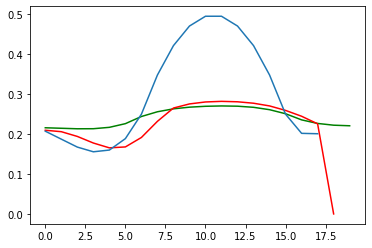

In [109]:
# plt.plot(xs[:,2], color = "black")
plt.plot(ik_com, color = "green")
plt.plot(com_bul[:,2][::int(dt/bul_dt)], color = "red")
plt.plot(com_opt[:,2][1:])

In [110]:
int_com = []
int_vel = []
int_vel.append(mom_opt[0,0:3])
int_com.append(com_opt[0])
cent_f = []
computed_cent_f = []
for i in range(1, len(com_opt)):
    f = np.reshape(F_opt[12*(i-1):12*i], (12,))
    tmp = np.array([np.sum(f[0::3]), np.sum(f[1::3]), np.sum(f[2::3]) - rmass*9.81])
    cent_f.append(tmp)
    computed_cent_f.append(rmass*(mom_opt[i][2] - mom_opt[i-1][2])/dt)
    int_vel.append(int_vel[i-1] + (1/rmass)*dt*tmp)

    int_com.append(int_com[i-1] + dt*mom_opt[i][0:3])    
#     int_com.append(int_com[i-1] + dt*int_vel[i])
    
int_vel = np.array(int_vel)   
int_com = np.array(int_com)
cent_f = np.array(cent_f)

print(int_com.shape, com_opt.shape)

(19, 3) (19, 3)


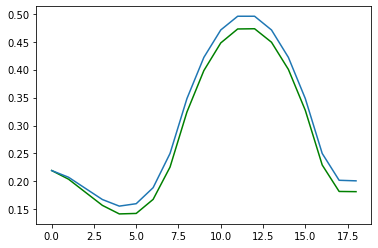

In [111]:
plt.plot(int_com[:,2], color = "green")
plt.plot(com_opt[:,2])

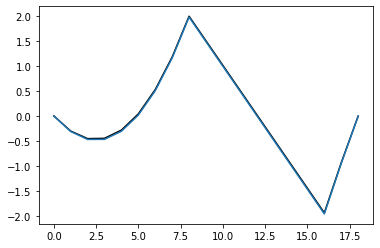

In [112]:
plt.plot(int_vel[:,2], color = "black")
plt.plot(mom_opt[:,2])

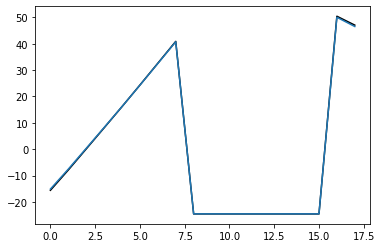

In [30]:
plt.plot(computed_cent_f, color = "black")
plt.plot(cent_f[:,2])